# Part 03. 흥미로운 GAN 기법

GAN의 핵심 아이디어를 조금 더 확장해 합성곱 신경망을 적용, 조건적 GAN을 통해 원하는 클래스의 데이터를 생성해본다.

## Chapter 09. 합성곱 GAN

CelelbA GAN을 기반으로, 두 가지 문제를 해결하는 모델을 만든다.

- 이전 CelebA GAN은 이미지가 불확실하게 보였다. 부드럽게 이어져야 할 공간들이 고대비 픽셀로 채워져 있었다.

- 완전 연결 신경망은 꽤 많은 메모리를 사용한다. 어느 정도 큰 이미지를 대상으로 훈련한다면 GPU의 한계를 넘어서서 훈련이 어려울 수 있다.


## Code Review

Import Library

In [ ]:
import h5py
import numpy
import zipfile
import imageio
import os
import random

import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset

GPU 확인

In [ ]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda: ", torch.cuda.get_device_name(0))
    pass

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

using cuda:  Tesla V100-SXM2-16GB


device(type='cuda')

Check Image size, shape

(218, 178, 3)


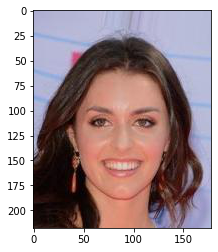

In [ ]:
import h5py

PATH = "/content/drive/MyDrive/workspace/GAN/GAN 첫걸음/celeba_dataset/celeba_aligned_small.h5py"

with h5py.File(PATH, 'r') as file_object:
    dataset = file_object['img_align_celeba']
    image = numpy.array(dataset['42.jpg'])
    plt.imshow(image, interpolation='none')
    pass

print(image.shape)

Cumstom Dataset

In [ ]:
class CelebADataset(Dataset):
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if (index >= len(self.dataset)):
            raise IndexError()

        img = numpy.array(self.dataset[str(index) + '.jpg'])
        return torch.cuda.FloatTensor(img) / 255.0

    def plot_image(self, index):
        plt.imshow(numpy.array(self.dataset[str(index) + '.jpg']), interpolation='nearest')

        pass

In [ ]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

In [ ]:
def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [ ]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

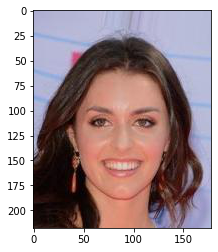

In [ ]:
celeba_dataset = CelebADataset('/content/drive/MyDrive/workspace/GAN/GAN 첫걸음/celeba_dataset/celeba_aligned_small.h5py')

celeba_dataset.plot_image(42)

Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            View(218*178*3),
            nn.Linear(3*218*178, 100),
            nn.LeakyReLU(),
            nn.LayerNorm(100),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

        self.loss = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0
        self.progress = []

        pass

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss(outputs, targets)

        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        pass

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass

    pass

Test Discriminator

In [ ]:
%%time

D = Discriminator().to(device)

for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
CPU times: user 2min 5s, sys: 3.48 s, total: 2min 9s
Wall time: 2min 9s


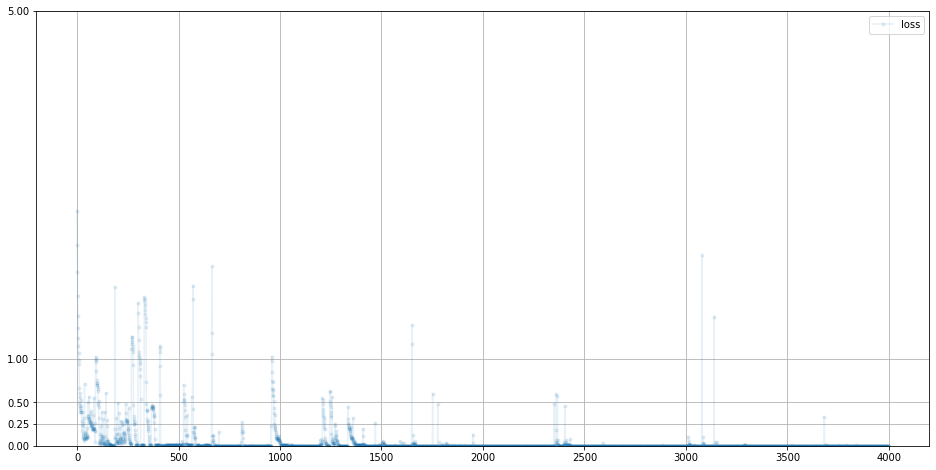

In [ ]:
D.plot_progress()

실제 데이터와, random_data를 잘 구별하는지 확인

In [ ]:
for i in range(4):
    image_data_tensor = celeba_dataset[random.randint(0, 20000)]
    print(D.forward(image_data_tensor).item())
    pass

for i in range(4):
    print(D.forward(generate_random_image((218,178,3))).item())
    pass

0.9998441934585571
0.9999780654907227
0.9996792078018188
0.999667763710022
0.00011239518062211573
0.00012022828013869002
9.477561252424493e-05
9.951134416041896e-05


Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),
            nn.LayerNorm(3*10*10),
            nn.Linear(3*10*10, 3*218*178),
            nn.Sigmoid(),
            View((218,178,3))
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        
        self.counter = 0
        self.progress = []
        
        pass

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        d_output = D.forward(g_output)
        loss = D.loss(d_output, targets)

        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        pass

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0.0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass

    pass

Test Generator

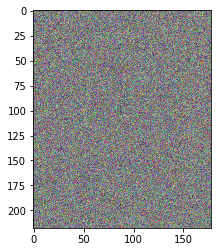

In [ ]:
G = Generator().to(device)

output = G.forward(generate_random_seed(100))
img = output.detach().cpu().numpy()
plt.imshow(img, interpolation='none', cmap='Blues')

Train GAN

In [ ]:
D = Discriminator().to(device)
G = Generator().to(device)

epochs = 6

for epoch in range(epochs):
    print("epoch: ", epoch + 1)

    for image_data_tensor in celeba_dataset:
        D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
        D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
        G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))
        pass
    pass

epoch:  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
epoch:  2
counter =  50000
counter =  60000
counter =  70000
counter =  80000
epoch:  3
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch:  4
counter =  130000
counter =  140000
counter =  150000
counter =  160000
epoch:  5
counter =  170000
counter =  180000
counter =  190000
counter =  200000
epoch:  6
counter =  210000
counter =  220000
counter =  230000
counter =  240000


Run Generator

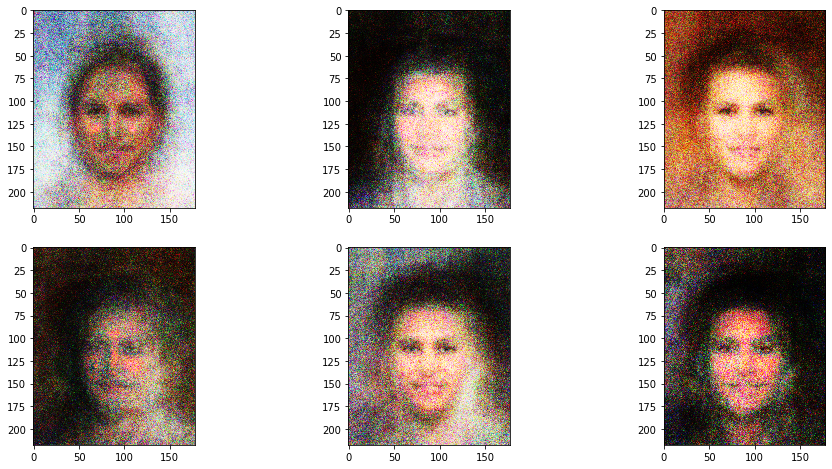

In [ ]:
f, axarr = plt.subplots(2, 3, figsize=(16, 8))

for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

### 메모리 소비

GAN이 메모리를 얼마나 소비하는지 확인해보자.

In [ ]:
torch.cuda.memory_allocated(device) / (1024*1024*1024) # 1024*1024*1024 로 나누어 단위를 바이트에서 기가바이로 바꾸었다. 

0.6999893188476562

GPU 메모리의 0.70GB가 텐서에 할당된 상태이다. 이 메모리에는 판별기와 생성기 객체 안의 데이터가 남아 있고, 다음에 다시 사용될 여지가 있으므로 사라진 상태가 아니다. 

출력된 메모리 사용량이 훈련에 필요한 모든 양을 표시하는 것은 아니다. 몇몇 메모리 공간은 훈련이 완료된 이후 비워졌기 때문이다. 따라서 아래 코드를 이용해서 실행 도중 도달한 최대 메모리 사용량을 측정할 수 있다. 

In [ ]:
torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

1.093554973602295

메모리 관련된 수치를 더 자세히 확인하고 싶다면 아래의 코드를 이용하자.

In [ ]:
print(torch.cuda.memory_summary(device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  733992 KB |    1119 MB |   94570 GB |   94569 GB |
|---------------------------------------------------------------------------|
| Active memory         |  733992 KB |    1119 MB |   94570 GB |   94569 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |    1220 MB |    1220 MB |    1220 MB |       0 B  |
|---------------------------------------------------------------

### 지역화된 이미지 특성

머신러닝의 황금 규칙은 가능한 모든 지식을 총동원해서 문제를 푸는 것이다.

도메인 지식(domain knowledge)를 활용해, 유효하지 않다는 걸 아는 방법들을 미리 배제해 문제의 크기를 줄일 수 있다. 이렇게 하면 학습 파라미터들은 잘 작동하는 조합들을 더 쉽게 찾아나갈 수 있어 머신러닝이 좀 더 빠르게 진행될 수 있다.

이미지로 생각해보면, 머신러닝을 위한 유의미한 특성(feature)은 이미지에서 지역화된(localized) 특성인 것을 알 수 있다. 예를 들어 눈과 코를 나타내는 픽셀은 가까이 붙어 있을 수 밖에 없다. 이런 정보는 이미지가 얼굴임을 분류할 때 중요하게 작동한다. 이러한 직관을 잘 이용하여, 이웃 픽셀들을 좀 더 고려하도록 신경망 분류기를 디자인할 수도 있다. 

이전의 MNIST, CelebA 분류기는 데이터에 대한 도메인 지식을 반영하지 않았다. 이미지상의 모든 픽셀을 항상 고려했다. 이미지 특성의 지역성을 고려하지 않음으로써, 훈련을 조금 더 무식하게 했다고 할 수 있다.

### 합성곱 필터

6 x 6 크기의 이미지가 있다고 해보자. 이미지에 대해 4 x 4 크기로 이미지의 일부를 탐색하는 돋보기 같은 게 있다고 하면, 이 돋보기를 이동해 예를 들어 눈이나 입의 일부만을 확인할 수 있다. 이 돋보기는 **지역성(Lcoality)**를 찾아내준다고 볼 수 있다.

이렇게 이미지를 보고 정보를 새로운 격자에 요약하는 방법을 **합성곱(convolution)**이라고 한다. 머신러닝에서는 돋보기와 실제 이미지 픽셀 사이에서 유사성을 찾는다고 할 수 있다.

이 과정을 더 정교화해보자. 돋보기에 어떤 편향이 있어서 어떠한 픽셀에서는 더 높은 점수를 주고 다른 픽셀에서는 낮은 점수를 준다고 해보자. 이 돋보기는 특정한 패턴을 골라내는 데 사용할 수 있다. 

이 돋보기의 제대로 된 이름은 **합성곱 커널(convolution kernel)** 이다. 


### 커널 가중치 학습하기

이미 만들어진 커널을 선별하는 것보다 훈련 시 제일 좋은 점수(가중치)를 내는 커널을 쓰는 것이다. 핵심은 먼저 훈련에 얼마나 많은 커널이 필요한지 정한다. 예를 들어 20개의 커널을 사용한다고 가정하면, 훈련 과정에서 20개의 커널의 가중치가 계속 조정될 것이다. 훈련이 성공적이라면, 이미지의 특징을 가장 잘 골라낸 **커널들을** 얻게된다. 여기서 얻은 정보를 결합해 신경망은 이미지를 분류하게 된다. 모든 커널이 다 쓸모 있는 것은 아니고, 이런 커널에 대해서 가중치를 낮춰 영향력을 낮춘다.


### 특성의 계층구조

합성곱 커널 레이어가 모서리나 점 같은 디테일한 저수준의 특성을 어떻게 골라내서 요약된 정보를 제공한다. 이러한 요약된 정보를 **특성 맵(feature map)**이라고 부른다.

이러한 특성 맵에 다시 합성곱 커널의 레이어를 추가하면 조금 더 추상적인 특성들의 조합으로 이뤄진 고수준의 특성을 얻을 수 있다. 예를 들어 모서리와 점을 적당히 조합하면 눈이나 코를 나타낼 수 있다.

이웃한 픽셀들의 작은 패턴에서 비롤된 중수준의 특성으로부터 이미지 내용을 만들어나가는 이러한 방식이 이미지 분류를 더 효과적으로 한다는 것은 분명하다. 이를 **합성곱 신경망(convolutional neural network, CNN)** 이라고 부른다.

$\Rightarrow$ CNN을 사용하는 요점은, 커널의 모양을 인간이 지정하는 대신 네트워크가 알 아서 훈련하게 한다는 것이다. 사실상 네트워크가 제일 유용한 저수준, 중수준, 고수준의 이미지 특성을 알아서 배우도록 하는 것이다.

### MNIST CNN

Dataset Class

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

In [ ]:
class MnistDataset(Dataset):
    def __init__(self, csv_file):
        self.data_df = pd.read_csv(csv_file, header=None)
        pass
        
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    pass

In [ ]:
mnist_dataset = MnistDataset('./drive/MyDrive/workspace/GAN/GAN_첫걸음/mnist_data/mnist_train.csv')

In [ ]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
            nn.Conv2d(10, 10, kernel_size=3, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),
            View(250),
            nn.Linear(250, 10), 
            nn.Sigmoid()
        )

        self.loss = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters())

        self.counter = 0
        self.progress = []

        pass

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss(outputs, targets)

        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        pass


    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

Train Neural Network

In [ ]:
%%time 

C = Classifier()

epochs = 3

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor.view(1, 1, 28, 28), target_tensor)
        pass
    pass

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 4min 45s, sys: 1.99 s, total: 4min 47s
Wall time: 4min 47s


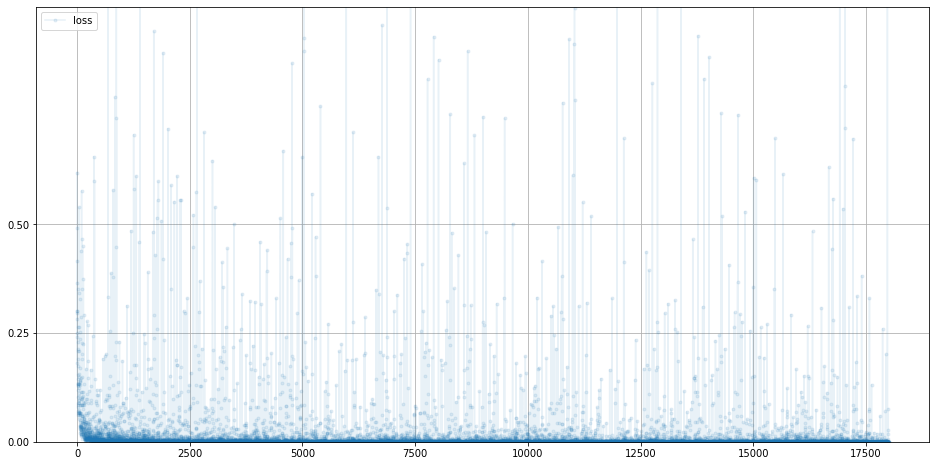

In [ ]:
C.plot_progress()

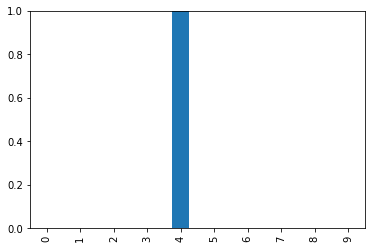

In [ ]:
mnist_test_dataset = MnistDataset('./drive/MyDrive/workspace/GAN/GAN_첫걸음/mnist_data/mnist_test.csv')

record = 19
image_data = mnist_test_dataset[record][1]
output = C.forward(image_data.view(1,1,28,28))
pd.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

In [ ]:
score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = C.forward(image_data_tensor.view(1,1,28,28)).detach().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1
    pass

print(score, items, score/items)

9811 10000 0.9811


### CelebA CNN

CelebA 이미지는 217 x 178 픽셀 크기를 가진다. 이를 128 x 128 이미지로 바꾸는 작업을 하자. 이미지를 중앙을 기준으로 잘라내 사용해야 한다.


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import pandas, numpy, random
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla P100-PCIE-16GB


device(type='cuda')

In [ ]:
def crop_centre(img, new_width, new_height):
    height, width, _ = img.shape
    startx = width // 2 - new_width // 2
    starty = height //2 - new_height // 2
    return img[starty:starty + new_height, startx:startx + new_width, :]

In [ ]:
class CelebADataset(Dataset):
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if (index >= len(self.dataset)):
            raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        img = crop_centre(img, 128, 128)
        return torch.cuda.FloatTensor(img).permute(2,0,1).view(1,3,128,128) / 255.0
    
    def plot_image(self, index):
        img = numpy.array(self.dataset[str(index) + '.jpg'])
        img = crop_centre(img, 128, 128)
        plt.imshow(img, interpolation='nearest')
        pass
    
    pass

(batch_size, channels, height, width) 형태의 4차원 텐서여야 한다.

현재 numpy matrix는 (height, width, 3) 형태의 3차원 행렬이다.

permute(2,0,1)을 통해 순서를 (3, height, width)로 바꾸고 view(1,3,128,128)로 배치 크기 1을 추가해 차원을 추가한다.

In [ ]:
celeba_dataset = CelebADataset('/content/drive/MyDrive/workspace/GAN/GAN_첫걸음/celeba_dataset/celeba_aligned_small.h5py')

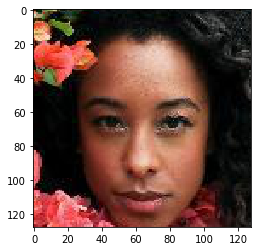

In [ ]:
celeba_dataset.plot_image(43)

In [ ]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

In [ ]:
def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=8, stride=2), 
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2), 
            
            nn.Conv2d(256, 3, kernel_size=8, stride=2),
            nn.LeakyReLU(0.2),

            View(3*10*10),
            nn.Linear(3*10*10, 1),
            nn.Sigmoid()
        )
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass


In [ ]:
%%time

D = Discriminator().to(device)

for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(generate_random_image((1,3,128,128)), torch.cuda.FloatTensor([0.0]))
    pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 8min 21s, sys: 3.18 s, total: 8min 24s
Wall time: 8min 24s


In [ ]:
D.plot_progress()

In [ ]:
for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0,20000)]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image((1,3,128,128))).item() )
  pass

1.0
1.0
1.0
1.0
2.297482097901593e-07
1.8717736338658142e-07
3.628544845923898e-06
2.319743998668855e-06


합성곱은 큰 텐서를 작은 텐서로 바꾸는 것이였다. 

합성곱이 반대 방향으로 동작하면 작은 텐서를 큰 텐서로 변화시켜야 한다. 

Pytorch는 이를 **전치 합성곱(Transposed Convolution)**이라고 부른다.
- nn.ConvTranspose2d 라는 모듈을 사용하면 된다.

생성기

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(100, 3*11*11),
            nn.LeakyReLU(0.2),
            View((1,3,11,11)),
            nn.ConvTranspose2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256), 
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0
        self.progress = []

    def forward(self, inputs):        
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)        
        d_output = D.forward(g_output)
        
        loss = D.loss_function(d_output, targets)

        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        pass
    
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

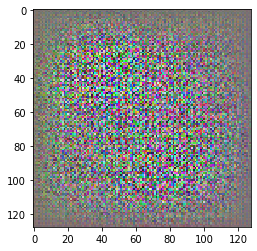

In [ ]:
G = Generator().to(device)

output = G.forward(generate_random_seed(100))
img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()
plt.imshow(img, interpolation='none', cmap='Blues')

In [ ]:
%%time

D = Discriminator().to(device)
G = Generator().to(device)

epochs = 1

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)


  for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))    
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))
    pass
  pass

epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 17min 8s, sys: 3.91 s, total: 17min 12s
Wall time: 17min 10s


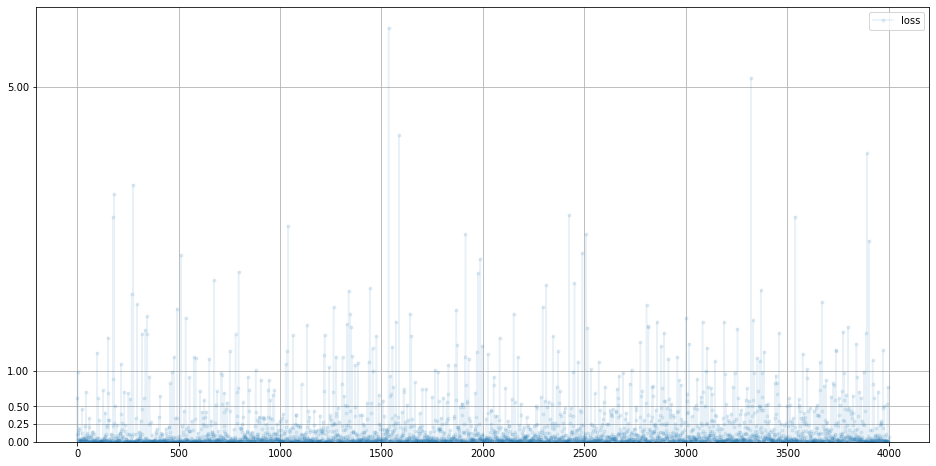

In [ ]:
D.plot_progress()

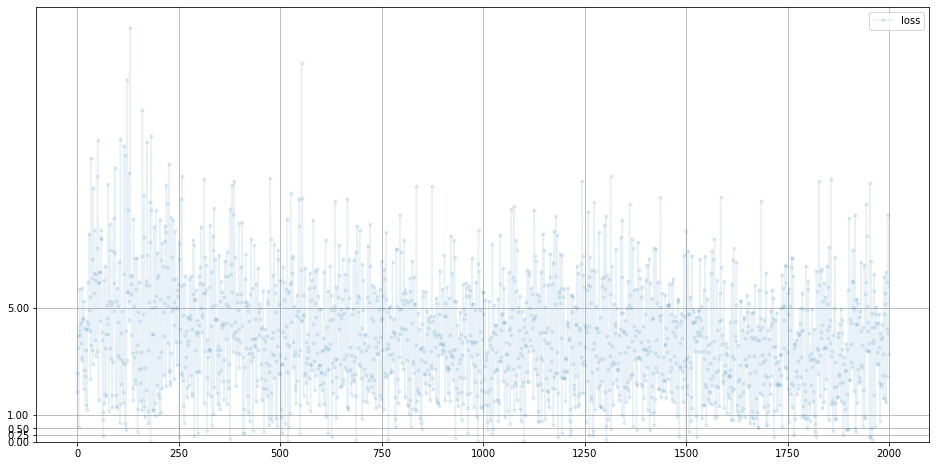

In [ ]:
G.plot_progress()

Run Generator

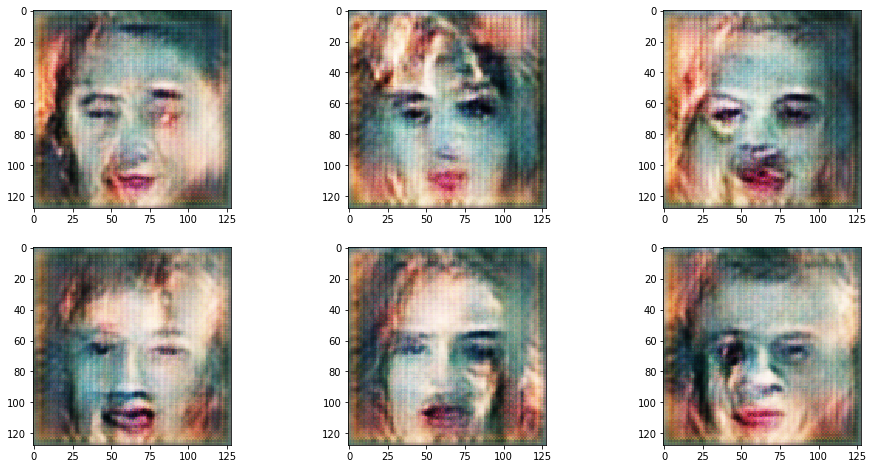

In [ ]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

In [ ]:
torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.35576725006103516

In [ ]:
torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

0.4171323776245117

GELU (Gaussian Error Linear Unit)
: ReLU와 비슷하지만 조금 더 부드러운 곡선을 지니고 있다. 

이 방법은 활성화 함수가 좋은 기울기를 제공하기 위해서는 함수 자체가 뾰족한 부분이 없어야 한다는 데에 착안해서 제안되었다.

In [1]:
# Import Package, Libarary
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
# Check CUDA and Set up

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("Using cuda:", torch.cuda.get_device_name(0))
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

Using cuda: Tesla P100-PCIE-16GB


device(type='cuda')

In [2]:
# Helper Function

def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


In [3]:
def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [4]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [5]:
def crop_centre(img, new_width, new_height):
    height, width, _ = img.shape
    startx = width // 2 - new_width // 2
    starty = height // 2 - new_height // 2
    return img[starty:starty + new_height, startx:startx + new_width, :]

In [9]:
class CelebADataset(Dataset):
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if (index >= len(self.dataset)):
            raise IndexError()
        img = np.array(self.dataset[str(index) + '.jpg'])
        img = crop_centre(img, 128, 128)
        return torch.cuda.FloatTensor(img).permute(2,0,1).view(1,3,128,128) / 255.0

    def plot_image(self, index):
        img = np.array(self.dataset[str(index) + '.jpg'])
        img = crop_centre(img, 128, 128)
        plt.imshow(img, interpolation='nearest')
        pass

    pass

In [10]:
celeba_dataset = CelebADataset('./drive/MyDrive/workspace/GAN/GAN_첫걸음/celeba_dataset/celeba_aligned_small.h5py')

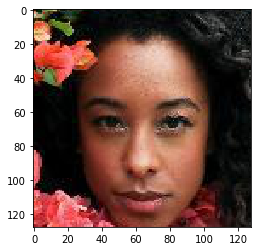

In [11]:
celeba_dataset.plot_image(43)

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 256, 8, 2),
            nn.BatchNorm2d(256),
            nn.GELU(),

            nn.Conv2d(256, 256, 8, 2),
            nn.BatchNorm2d(256),
            nn.GELU(),

            nn.Conv2d(256, 3, 8, 2),
            nn.GELU(),
            
            View(3*10*10),
            nn.Linear(3*10*10,1),
            nn.Sigmoid()
        )

        self.loss = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0
        self.progress = []

        pass

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss(outputs, targets)

        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("Counter = ", self.counter)
            pass

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        pass

    def plot_image(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0.0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass

    pass

In [18]:
%%time

D = Discriminator().to(device)

for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(generate_random_image((1,3,128,128)), torch.cuda.FloatTensor([0.0]))
    pass

Counter =  10000
Counter =  20000
Counter =  30000
Counter =  40000
CPU times: user 8min 26s, sys: 2.98 s, total: 8min 29s
Wall time: 8min 46s


In [27]:
# Check running Discriminator

for i in range(4):
    image_data_tensor = celeba_dataset[random.randint(0, 20000)]
    print(D.forward(image_data_tensor).item())
    pass

for i in range(4):
    print(D.forward(generate_random_image((1,3,128,128))).item())

1.0
1.0
1.0
1.0
6.439735500407551e-08
1.01027308740953e-09
1.0854623724299017e-06
1.1176483738495335e-08


In [24]:
# Generator

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(100, 3*11*11),
            nn.GELU(),

            View((1,3,11,11)),
            
            nn.ConvTranspose2d(3, 256, 8, 2),
            nn.BatchNorm2d(256),
            nn.GELU(), 

            nn.ConvTranspose2d(256,256,8,2),
            nn.BatchNorm2d(256),
            nn.GELU(),

            nn.ConvTranspose2d(256,3,8,2,1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0
        self.progress = []

        pass

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        d_output = D.forward(g_output)

        loss = D.loss(d_output, targets)

        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        pass


    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

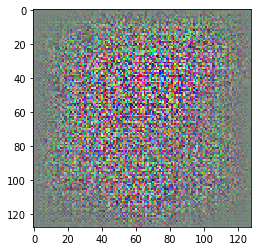

In [25]:
G = Generator().to(device)

output = G.forward(generate_random_seed(100))
img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()
plt.imshow(img, interpolation='none', cmap='Blues')

In [ ]:
# Train GAN
%%time

D = Discriminator().to(device)
G = Generator().to(device)

epochs = 10

for epoch in range(epochs):
    print("epoch:", epoch+1)

    for image_data_tensor in celeba_dataset:
        D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
        D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
        G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

epoch: 1
Counter =  10000
Counter =  20000
Counter =  30000
Counter =  40000
epoch: 2
Counter =  50000
Counter =  60000
Counter =  70000


In [ ]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

### Summary

- 이미지 판별기는 **지역** 정보를 통해 의미 있는 이미지 특징을 찾을 수 있다는 점을 활용한다. 이러한 특성은 저, 중, 고수준으로 **계층적**으로 이뤄져있다.

- **합성곱**은 **특성 맵**을 산출하기 위해 이미지 **커널**을 적용한다. 특정 커널은 이미지에서 지역화된 특성을 찾아낼 수 있다.

- 신경망의 합성곱 레이어는 주어진 작업에 대해 좋은 커널을 학습할 수 있다. 즉, 신경망에서 어떤 이미지 특성이 제일 쓸모 있는지 일일이 알려주지 않아도 된다는 것이다. 합성곱을 이용하는 신경망은 완전 연결 신경망 보다 보통 더 나은 성능을 보인다.

- 데이터를 줄이는 합성곱의 반대 역할은 하는게 **전치 합성곱**이며, 생성적 네트워크를 만들기에 이상적이다.

- 합성곱 생성기의 한 단점은 예를 들어 얼굴과 눈이 따로 노는 등 얼굴 요소끼리 조화가 깨질 수 있다는 점이다. 합성곱 신경망을 타고 흐르는 정보는 지역화된 정보이며 따라서 전체적인 관계는 학습하지 않게 구현했기 때문이다.

## Chapter 10. 조건부 GAN

GAN이 생성하는 이미지를 단일한 클래스로 고정한 채로 다양한 이미지를 생성할 수 있다면 유용할 것이다. (예를 들면, 숫자 3을 표현하는 다양한 이미지를 생성하라고 요청, 훈련 데이터에 감정을 나타내는 클래스가 있고 얼굴 이미지로 훈련 하고 있다면, 행복한 표정의 얼굴만 만들라고 요청을할 수 도 있을 것이다.)


### 조건부 GAN 구조

훈련된 GAN 생성기가 주어진 클래스에 해당하는 이미지를 생성하게 하려면, 일단 무슨 클래스를 목표로 하는지 생성기에게 알려줘야 한다. 즉, 생성기에 임의의 시드와 함께 어떤 이미지를 원하는지 입력을 넣어줘야 한다는 뜻이다.

이전에 판별기는 생성기에서 생성된 이미지와 실제 이미지를 구별하는 일이었다. 하지만 이제는 클래스 레이블과 이미지 사이의 관계를 학습해야 한다. 즉, 판별기에도 클래스 레이블에 대한 정보를 같이 제공해줘야 한다.

이러한 GAN 구조를 **조건부 GAN(Conditional GAN)**이라고 한다.

**판별기, 생성기 모두 클래스 레이블 정보를 추가로 입력 받는다.**

In [1]:
# Import Package, Libarary
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
class MnistDataset(Dataset):
    def __init__(self, csv_file):
        self.data_df = pd.read_csv(csv_file, header=None)
        pass

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        label = self.data_df.iloc[index, 0]
        target = torch.zeros((10))
        target[label] = 1.0

        image_values = torch.FloatTensor(self.data_df.iloc[index, 1:].values / 255.0)
        return label, image_values, target

    def plot_image(self, index):
        img = self.data_df.iloc[index, 1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index, 0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass

    pass

In [3]:
mnist_dataset = MnistDataset('./drive/MyDrive/workspace/GAN/GAN_첫걸음/mnist_data/mnist_train.csv')

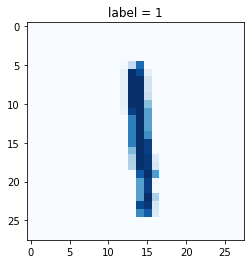

In [4]:
mnist_dataset.plot_image(8)

Label Tensor는 **원핫 인코딩** 되어 있는 텐서이다. 

In [5]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data


def generate_random_one_hot(size):
    label_tensor = torch.zeros((size))
    random_idx = random.randint(0, size-1)
    label_tensor[random_idx] = 1.0
    return label_tensor

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(794, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 1), 
            nn.Sigmoid()
        )

        self.loss = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.counter = 0
        self.progress = []


    def forward(self, image_tensor, label_tensor):
        inputs = torch.cat((image_tensor, label_tensor)) # 784 + 10 = 794
        return self.model(inputs)


    def train(self, inputs, label_tensor, targets):
        outputs = self.forward(inputs, label_tensor)
        loss = self.loss(outputs, targets)

        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        pass


    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0.0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 0.5))
        pass

    pass

In [8]:
%%time

D = Discriminator()

for label, image_data_tensor, label_tensor in mnist_dataset:
    D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))
    D.train(generate_random_image(784), generate_random_one_hot(10), torch.FloatTensor([0.0]))
    pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
counter =  59000
counte

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(110, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 784), 
            nn.Sigmoid()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0
        self.progress = []

    def forward(self, seed_tensor, label):
        inputs = torch.cat((seed_tensor, label_tensor))
        return self.model(inputs)

    def train(self, D, inputs, label_tensor, targets):
        g_output = self.forward(inputs, label_tensor)
        d_output = D.forward(g_output, label_tensor)
        loss = D.loss(d_output, targets)

        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        pass

    def plot_images(self, label):
        label_tensor = torch.zeros((10))
        label_tensor[label] = 1.0
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                axarr[i,j].imshow(G.forward(generate_random_seed(100), label_tensor).detach().cpu().numpy().reshape(28,28), interpolation='none', cmap='Blues')
                pass
            pass
        pass
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass



In [11]:
D = Discriminator()
G = Generator()

for label, image_data_tensor, label_tensor in mnist_dataset:
    D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))
    random_label = generate_random_one_hot(10)
    D.train(G.forward(generate_random_seed(100), random_label).detach(), random_label, torch.FloatTensor([0.0]))
    random_label = generate_random_one_hot(10)
    G.train(D, generate_random_seed(100), random_label, torch.FloatTensor([1.0]))
    pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
counter =  59000
counte

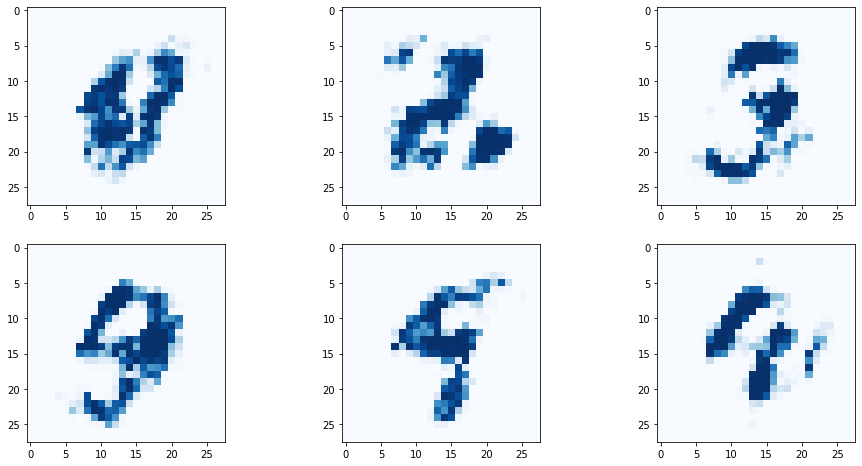

In [12]:
G.plot_images(9)

중요한 요구 사항은 사전에 훈련 데이터에서 레이블링이 잘 이뤄져 있어야 한다.

### Summary

- 일반적인 GAN과 달리, **조건부 GAN**은 원하는 클래스의 데이터 생성이 가능하다.

- 조건부 GAN은 훈련 시 판별기에 이미지를 보강해서 전달하며, 생성기에는 **클래스 레이블**을 통해 시드가 투입되어야 한다.

- 조건부 GAN은 레이블 정보를 받지 않는 일반적인 GAN보다 좋은 이미지 품질의 데이터를 생산한다.

## Chapter 11. Result